# Transfer learning and fine-tuning

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world.

There are two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. We simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that wecan repurpose the feature maps learned previously for the dataset.

We do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

2. Fine-Tuning: Unfreeze a few of the last layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


### Use data augmentation

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.25),
  tf.keras.layers.RandomFlip('horizontal')
])

Let's repeatedly apply these layers to the same image and see the result.

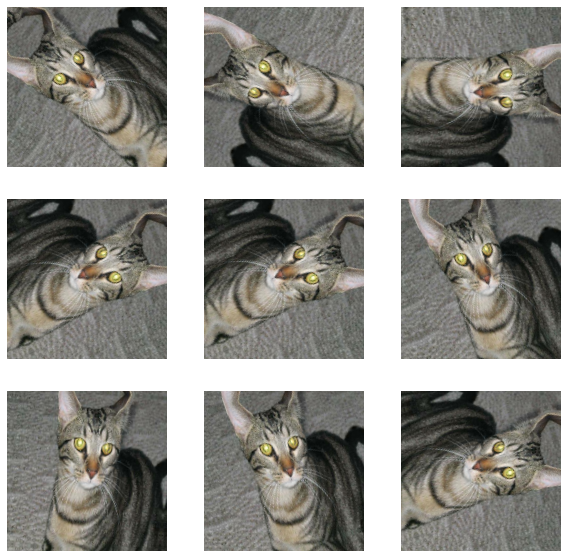

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))

    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Exercise:

Apply Vertical Flip and Random Rotation for a range (-0.25, 0.25) for a an image of training set and visualise the images

Refer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation

In [ ]:
# TO DO:
# data_aug_2 = ...


### Rescale pixel values

This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in our images are in `[0, 255]`.

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Create the base model from the pre-trained convnets
We will create the base model from the **ResNet** model.

First, we need to pick which layer we will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, we will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a ResNet model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 [==============================] - 0s 0us/step


## Feature extraction
In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, we add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. Setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When we set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When we unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, we should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.


In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. We don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

### Train the model



In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

32/32 [==============================] - 12s 80ms/step - loss: 1.5249 - accuracy: 0.4910


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.52
initial accuracy: 0.49


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10


63/63 [==============================] - 18s 185ms/step - loss: 0.3849 - accuracy: 0.8210 - val_loss: 0.0850 - val_accuracy: 0.9710
Epoch 2/10
63/63 [==============================] - 11s 176ms/step - loss: 0.1894 - accuracy: 0.9135 - val_loss: 0.0607 - val_accuracy: 0.9850
Epoch 3/10
63/63 [==============================] - 11s 174ms/step - loss: 0.1533 - accuracy: 0.9350 - val_loss: 0.0596 - val_accuracy: 0.9840
Epoch 4/10
63/63 [==============================] - 12s 188ms/step - loss: 0.1336 - accuracy: 0.9385 - val_loss: 0.0520 - val_accuracy: 0.9860
Epoch 5/10
63/63 [==============================] - 12s 181ms/step - loss: 0.1256 - accuracy: 0.9505 - val_loss: 0.0485 - val_accuracy: 0.9860
Epoch 6/10
63/63 [==============================] - 11s 177ms/step - loss: 0.1277 - accuracy: 0.9480 - val_loss: 0.0565 - val_accuracy: 0.9840
Epoch 7/10
63/63 [==============================] - 13s 202ms/step - loss: 0.1234 - accuracy: 0.9485 - val_loss: 0.0457 - val_accuracy: 0.9830
Epoch 8/10

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the base model as a fixed feature extractor.

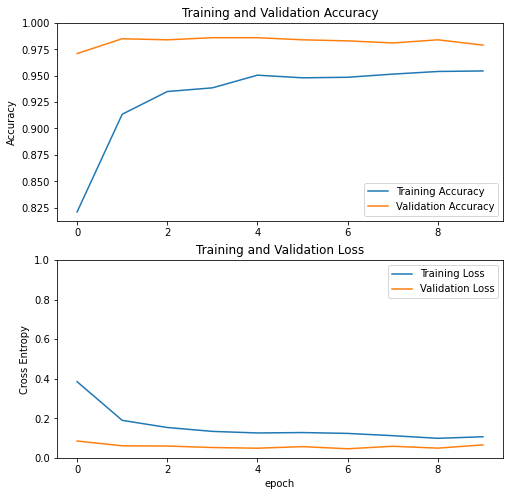

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In the feature extraction experiment, we were only training a few layers on top of a base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


In [ ]:
base_model.trainable = True

### EXERCISE: TRAINING THE LAST 15 LAYERS OF THE MODEL

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [ ]:
#TO DO:

#fine_tune_at = ...


# Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
# ....



Compile the model

As we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, our model could overfit very quickly.

In [ ]:
## TO DO: Compile the model for a learning rate = 0.1*base_learning_rate (0.001)



In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

### Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 16s 244ms/step - loss: 0.1011 - accuracy: 0.9595 - val_loss: 0.0436 - val_accuracy: 0.9810
Epoch 11/20
63/63 [==============================] - 11s 179ms/step - loss: 0.0970 - accuracy: 0.9555 - val_loss: 0.0491 - val_accuracy: 0.9840
Epoch 12/20
63/63 [==============================] - 11s 178ms/step - loss: 0.0917 - accuracy: 0.9640 - val_loss: 0.0452 - val_accuracy: 0.9840
Epoch 13/20
63/63 [==============================] - 12s 190ms/step - loss: 0.0969 - accuracy: 0.9605 - val_loss: 0.0578 - val_accuracy: 0.9860
Epoch 14/20
63/63 [==============================] - 12s 185ms/step - loss: 0.0897 - accuracy: 0.9600 - val_loss: 0.0618 - val_accuracy: 0.9810
Epoch 15/20
63/63 [==============================] - 11s 177ms/step - loss: 0.0971 - accuracy: 0.9595 - val_loss: 0.0470 - val_accuracy: 0.9850
Epoch 16/20
63/63 [==============================] - 11s 176ms/step - loss: 0.0826 - accuracy: 0.9660 - val_loss: 0.0518 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

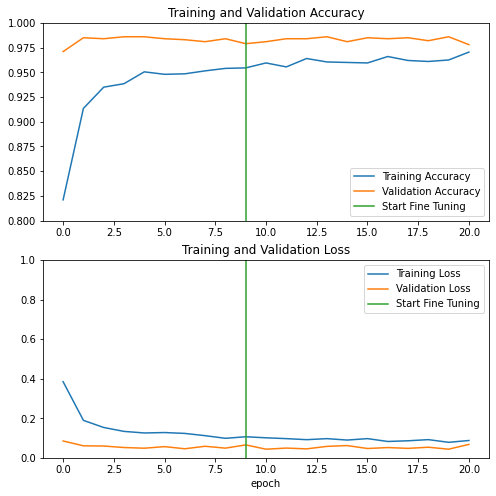

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Pytorch



In [ ]:
from torchvision.transforms.transforms import RandomRotation

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((160,160)),
        transforms.RandomRotation(0.25),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),

    ]),
    'validation': transforms.Compose([
        transforms.Resize((160,160)),
        transforms.RandomRotation(0.25),
        transforms.ToTensor(),

    ]),
}

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
data_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation']}




dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


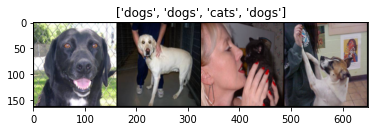

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer,  num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)



            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                       num_epochs=10)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/9
----------
train Loss: 0.4888 Acc: 0.8220
validation Loss: 0.5441 Acc: 0.8040

Epoch 1/9
----------
train Loss: 0.3651 Acc: 0.8615
validation Loss: 0.0862 Acc: 0.9710

Epoch 2/9
----------
train Loss: 0.3996 Acc: 0.8510
validation Loss: 0.1218 Acc: 0.9570

Epoch 3/9
----------
train Loss: 0.3776 Acc: 0.8630
validation Loss: 0.1062 Acc: 0.9610

Epoch 4/9
----------
train Loss: 0.3671 Acc: 0.8650
validation Loss: 0.1272 Acc: 0.9510

Epoch 5/9
----------
train Loss: 0.3850 Acc: 0.8580
validation Loss: 0.0840 Acc: 0.9640

Epoch 6/9
----------
train Loss: 0.4053 Acc: 0.8625
validation Loss: 0.2025 Acc: 0.9330

Epoch 7/9
----------
train Loss: 0.3344 Acc: 0.8820
validation Loss: 0.1494 Acc: 0.9380

Epoch 8/9
----------
train Loss: 0.3649 Acc: 0.8690
validation Loss: 0.1496 Acc: 0.9420

Epoch 9/9
----------
train Loss: 0.3061 Acc: 0.8895
validation Loss: 0.0928 Acc: 0.9630

Training complete in 3m 52s
Best val Acc: 0.971000


### EXERCISE:


In [ ]:
model_ft = models.resnet50(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False

## TO DO: TRAINING THE LAST 15 LAYERS OF THE MODEL
## Specify where `param.requires_grad` is TRUE and where it is FALSE using a for loop


# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
summary(model_ft, (3, 160, 160))
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4312 Acc: 0.7935
validation Loss: 0.2308 Acc: 0.9380

Epoch 1/9
----------
train Loss: 0.3297 Acc: 0.8605
validation Loss: 0.1684 Acc: 0.9520

Epoch 2/9
----------
train Loss: 0.2901 Acc: 0.8745
validation Loss: 0.1458 Acc: 0.9550

Epoch 3/9
----------
train Loss: 0.3035 Acc: 0.8615
validation Loss: 0.1476 Acc: 0.9540

Epoch 4/9
----------
train Loss: 0.2763 Acc: 0.8780
validation Loss: 0.1378 Acc: 0.9600

Epoch 5/9
----------
train Loss: 0.2611 Acc: 0.8850
validation Loss: 0.1228 Acc: 0.9600

Epoch 6/9
----------
train Loss: 0.2785 Acc: 0.8870
validation Loss: 0.1280 Acc: 0.9570

Epoch 7/9
----------
train Loss: 0.2960 Acc: 0.8765
validation Loss: 0.1300 Acc: 0.9590

Epoch 8/9
----------
train Loss: 0.2723 Acc: 0.8820
validation Loss: 0.1111 Acc: 0.9630

Epoch 9/9
----------
train Loss: 0.2938 Acc: 0.8765
validation Loss: 0.1189 Acc: 0.9620

Training complete in 3m 29s
Best val Acc: 0.963000


# Generative Adversarial Networks

- Given a training set, this technique learns to generate new data with the same statistics as the training set.
- The core idea of a GAN is based on the "indirect" training through the discriminator, another neural network that is able to tell how much an input is "realistic", which itself is also being updated dynamically.
- This basically means that the generator is not trained to minimize the distance to a specific image, but rather to fool the discriminator.

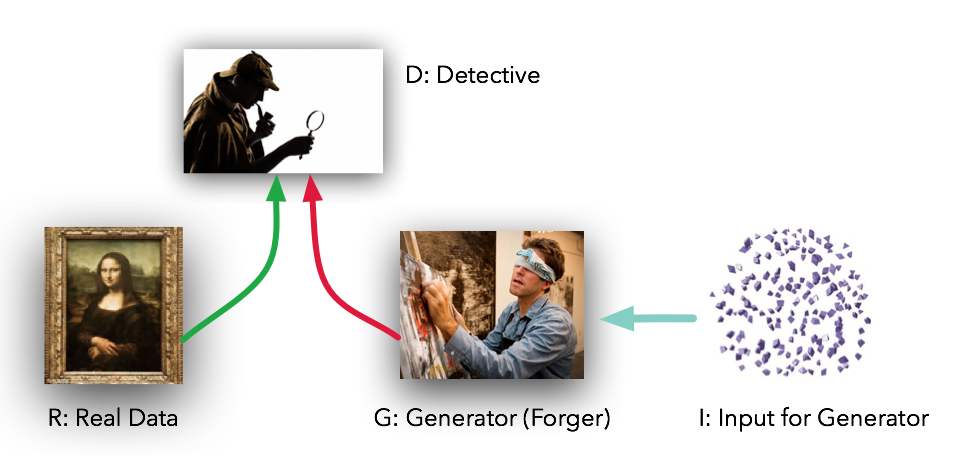

Discriminator output is the probability that an image is real
 - $p \approx 1$ -> Image came from original distribution
 - $p \approx 0$ -> Image came from generator

## GAN Loss Function

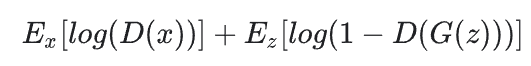

Discriminator would maximize this
 - $D(x)$ would be close to 1 -> $\log D(x)$ would be close to 0
 -  $D(G(z))$ would be close to 0 -> $\log(1 - D(G(z)))$ would be close to 0

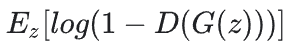

Generator would minimuze this
 - $D(G(z))$ would be close to 0 -> $\log(1 - D(G(z))$ would be close to $-\infty$

#### Getting the CelebA data

In [ ]:
!mkdir celeba_gan
!gdown "1qAzXuuMPSvkDSDsarc4O1Y7yFKSi6ekr&confirm=t" -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

mkdir: cannot create directory ‘celeba_gan’: File exists
Downloading...
From: https://drive.google.com/uc?id=1qAzXuuMPSvkDSDsarc4O1Y7yFKSi6ekr&confirm=t
To: /content/celeba_gan/data.zip
100% 1.43G/1.43G [00:18<00:00, 79.2MB/s]


In [ ]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True)

Found 202599 files belonging to 1 classes.


In [ ]:
dataset = dataset.map(lambda x: x / 255.)


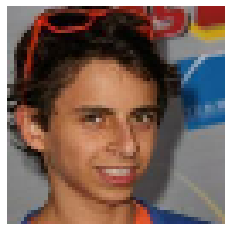

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

#### Discriminator

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [ ]:
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

#### Generator

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
generator.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

#### The GAN Model

In [ ]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )

        # Add noise to discriminator labels to make it's job harder
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

#### Callback to sample images from each epoch

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


In [ ]:
epochs =5

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/5
6332/6332 [==============================] - 1924s 304ms/step - d_loss: 0.6566 - g_loss: 1.0683
Epoch 2/5
6332/6332 [==============================] - 1926s 304ms/step - d_loss: 0.6746 - g_loss: 0.9740
Epoch 3/5
6332/6332 [==============================] - 1926s 304ms/step - d_loss: 0.6695 - g_loss: 1.0122
Epoch 4/5
6332/6332 [==============================] - 1926s 304ms/step - d_loss: 0.6568 - g_loss: 1.0416
Epoch 5/5
6332/6332 [==============================] - 1927s 304ms/step - d_loss: 0.6528 - g_loss: 0.9917


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


def read_imgs():
    img_arr = []
    for i in range(5):
      for j in range(10):
        img = Image.open('./generated_img_00'+str(i)+'_'+str(j)+'.png').convert('RGB')
        img = np.asarray(img)
        img_arr.append(img)
    return img_arr

In [ ]:
imgs = read_imgs()

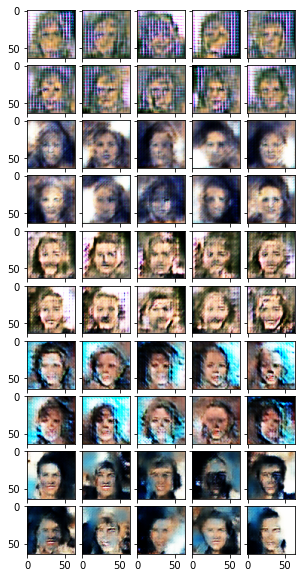

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, imgs):
    ax.imshow(im)

plt.show()

For PyTorch - [refer here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)